In [1]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean
import xesmf as xe
import sectionate
from geopy import distance
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/src')
from src import *

In [2]:
plotsdir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/figures/" + x
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/" + x

In [3]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmolkg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmolkg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'PuRd','units':'fmolkg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='150GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=16)
from dask.distributed import Client
client = Client(cluster)


#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=140G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/bin/python -m distributed.cli.dask_worker tcp://172.16.3.71:38486 --nthreads 36 --memory-limit 139.70GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.71:38486,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
def time_z_mean(ds, varn, ystart, yend, zmin, zmax):
    ds_mean = ds[varn].sel(year = slice(ystart, yend)).mean(["year"]).compute()
    ds_z_mean = ds.z.sel(year = slice(ystart, yend)).mean(["year"]).compute()
    ds_thick_mean = ds.thkcello.sel(year = slice(ystart, yend)).mean(["year"]).compute()
    
    mask = (ds_z_mean > zmin) * (ds_z_mean < zmax)
    weights = mask * ds_thick_mean

    ds_mean_level = (weights * ds_mean).sum("zl") / weights.sum("zl")
    return ds_mean_level * variable_kwargs[varn]['conversion']

In [7]:
ds_GLODAPP = xr.open_dataset(datadir("GLODAP_gridded.nc")).compute()
ds_GLODAPP = ds_GLODAPP.rename({"G2salinity":"salinity", "G2temperature":"theta"})
ds_GLODAPP["depth"] = ds_GLODAPP.z
ds_GLODAPP = get_thetao(ds_GLODAPP)
ds_GLODAPP = get_sigma2(ds_GLODAPP)
cfc_gridded = ds_GLODAPP.G2cfc12

In [8]:
def read_CM4X(fname): 
    ds = xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":20, "longitude":20, "zl":-1, "year":20},
        engine="zarr")
    ds = ds.drop(["lat", "lon"])
    ds = ds.rename({"geolat":"lat", "geolon":"lon"})
    ds = approximate_z(ds)
    ds["z"] = ds["z"].transpose("year", "zl", "yh", "xh")
    ds["thkcello"] = ds["thkcello"].transpose("year", "zl", "yh", "xh")
    return ds


ds = read_CM4X(datadir("CM4Xp125_historical_transient_tracers.zarr"))
regridder = xe.Regridder(ds, ds_GLODAPP, method = "bilinear", periodic = True, parallel = False) #need to put Periodic = True for MOM6
ds_regrid = regridder(ds)
ds_regrid = get_sigma2(ds_regrid)
ds_lo = read_CM4X(datadir("CM4Xp25_historical_transient_tracers.zarr"))
regridder = xe.Regridder(ds_lo, ds_GLODAPP, method = "bilinear", periodic = True, parallel = False) #need to put Periodic = True for MOM6
ds_regrid_lo = regridder(ds_lo)
ds_regrid_lo = get_sigma2(ds_regrid_lo)


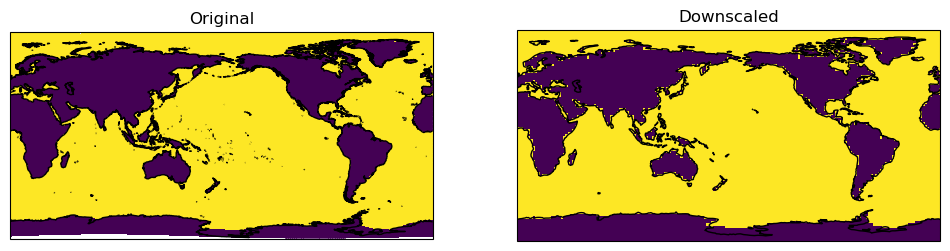

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 10), subplot_kw={'projection':ccrs.PlateCarree(central_longitude = 180)})

axes = ax[0]
axes.set_title("Original")
axes.pcolormesh(ds.lon, ds.lat, (ds["deptho"] > .01), transform=ccrs.PlateCarree())
axes.coastlines(resolution='50m',)

regridder = xe.Regridder(ds.deptho, ds_GLODAPP, method = "bilinear", periodic = True, parallel = False) #need to put Periodic = True for MOM6
dr_out = regridder(ds.deptho.compute())

axes = ax[1]
axes.set_title("Downscaled")
axes.pcolormesh(dr_out.lon, dr_out.lat, (dr_out > .01), transform=ccrs.PlateCarree())
axes.coastlines(resolution='110m',)

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/xarray/core/computation.py:760: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


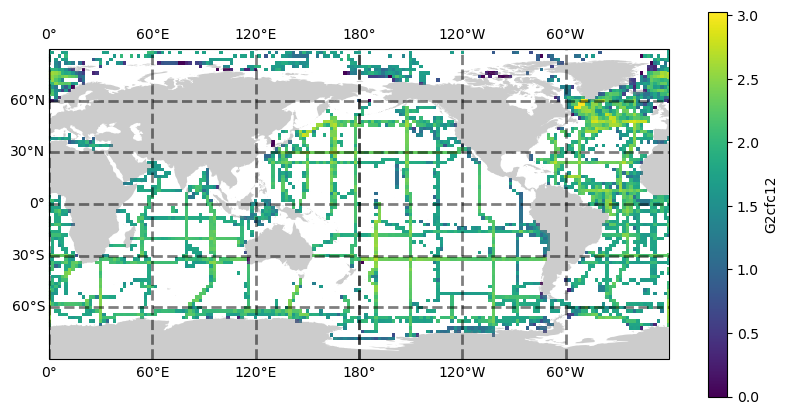

In [10]:
import cartopy.feature as cfeature;
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude = 180)})
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='grey', alpha = 0.4))
np.log10(((~np.isnan(cfc_gridded)).sum(["time", "z"]))).T.plot(ax = ax,transform=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
# ax.coastlines()


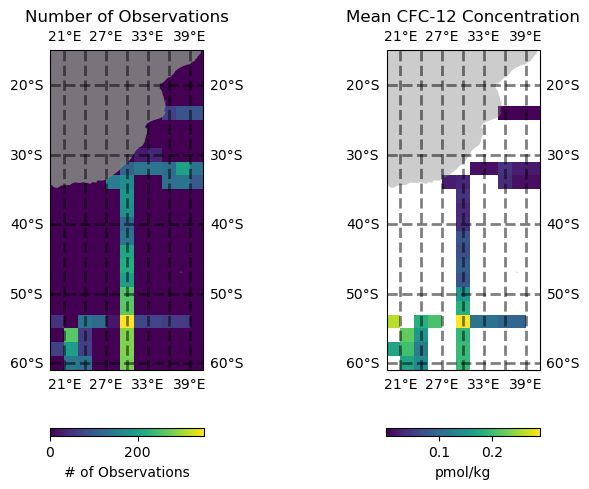

In [11]:
import cartopy.feature as cfeature;
fig, axes = plt.subplots(1, 2, figsize=(7.0, 5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude = 180)})

ax = axes[0]
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='grey', alpha = 0.9))
tmp = (((~np.isnan(cfc_gridded)).sum(["time", "z"]))).T

tmp.sel(lat = slice(-60, 0-15), lon = slice(20, 40)).plot(ax = ax,transform=ccrs.PlateCarree(),
                                                          cbar_kwargs = {"label":"# of Observations",
                                                                        "orientation":"horizontal",
                                                                        "fraction":0.02})
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
ax.set_title("Number of Observations")
ax = axes[1]

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='grey', alpha = 0.4))
tmp = (cfc_gridded).sel(z = slice(-3000, -6000)).mean(["time", "z"]).T

tmp.sel(lat = slice(-60, 0-15), lon = slice(20, 40)).plot(ax = ax,transform=ccrs.PlateCarree(),
                                                          cbar_kwargs = {"label":"pmol/kg",
                                                                        "orientation":"horizontal",
                                                                        "fraction":0.02})
ax.set_title("Mean CFC-12 Concentration")

gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
fig.tight_layout()


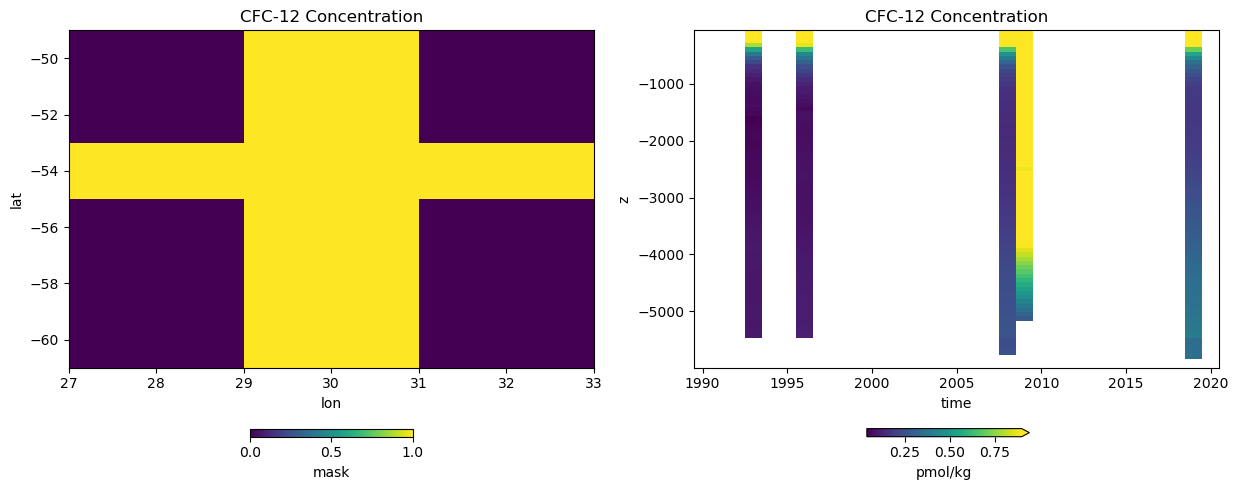

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12.5, 5))

mask = ((~np.isnan(cfc_gridded)).sum(["time", "z"]) > 1).sel(lat = slice(-60, -50), lon = slice(27, 33))
mask.T.plot(ax = axes[0],
                                                          cbar_kwargs = {"label":"mask",
                                                                        "orientation":"horizontal",
                                                                        "fraction":0.02})
axes[0].set_title("CFC-12 Concentration")

GLODAP_profile = ds_GLODAPP.sel(lat = mask.lat, lon = mask.lon).mean(["lon", "lat"])
GLODAP_profile.G2cfc12.T.plot(vmax = 0.9, ax = axes[1],
                                                          cbar_kwargs = {"label":"pmol/kg",
                                                                        "orientation":"horizontal",
                                                                        "fraction":0.02})
axes[1].set_title("CFC-12 Concentration")
fig.tight_layout()

In [13]:
regrid_cfc12 = ds_regrid.sel(lat = mask.lat, lon = mask.lon)
weights = (regrid_cfc12.z > -105.0) * (regrid_cfc12.z < -95.0)
weights = weights * regrid_cfc12.thkcello * mask.T
regrid_cfc12 = (regrid_cfc12.cfc12 * weights).sum(["lat", "lon", "zl"]) / weights.sum(["lat", "lon", "zl"])
regrid_cfc12 = regrid_cfc12.compute()

In [14]:
regrid_cfc12_lo = ds_regrid_lo.sel(lat = mask.lat, lon = mask.lon)
weights = (regrid_cfc12_lo.z > -105.0) * (regrid_cfc12_lo.z < -95.0)
weights = weights * regrid_cfc12_lo.thkcello * mask.T
regrid_cfc12_lo = (regrid_cfc12_lo.cfc12 * weights).sum(["lat", "lon", "zl"]) / weights.sum(["lat", "lon", "zl"])
regrid_cfc12_lo = regrid_cfc12_lo.compute()



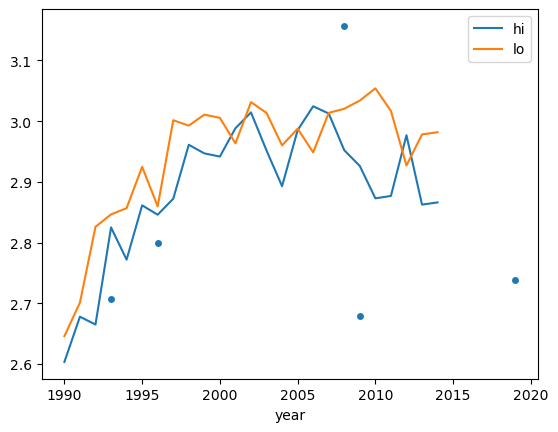

In [15]:
GLODAP_profile.G2cfc12.isel(z = 0).drop("z").plot.scatter()

(regrid_cfc12.sel(year = slice(1990, None)) * variable_kwargs["cfc12"]['conversion']).plot(label = "hi")

(regrid_cfc12_lo.sel(year = slice(1990, None)) * variable_kwargs["cfc12"]['conversion']).plot(label = "lo")
plt.legend()

In [16]:
regrid_cfc12 = ds_regrid.sel(lat = mask.lat, lon = mask.lon)
weights = (regrid_cfc12.sigma2 > 37.2)
weights = weights * regrid_cfc12.thkcello * mask.T
regrid_cfc12 = (regrid_cfc12.cfc12 * weights).sum(["lat", "lon", "zl"]) / weights.sum(["lat", "lon", "zl"])
regrid_cfc12 = regrid_cfc12.compute()

In [17]:
regrid_cfc12_lo = ds_regrid_lo.sel(lat = mask.lat, lon = mask.lon)
weights = (regrid_cfc12_lo.sigma2 > 37.2)
weights = weights * regrid_cfc12_lo.thkcello * mask.T
regrid_cfc12_lo = (regrid_cfc12_lo.cfc12 * weights).sum(["lat", "lon", "zl"]) / weights.sum(["lat", "lon", "zl"])
regrid_cfc12_lo = regrid_cfc12_lo.compute()

Text(0, 0.5, 'pmol/kg')

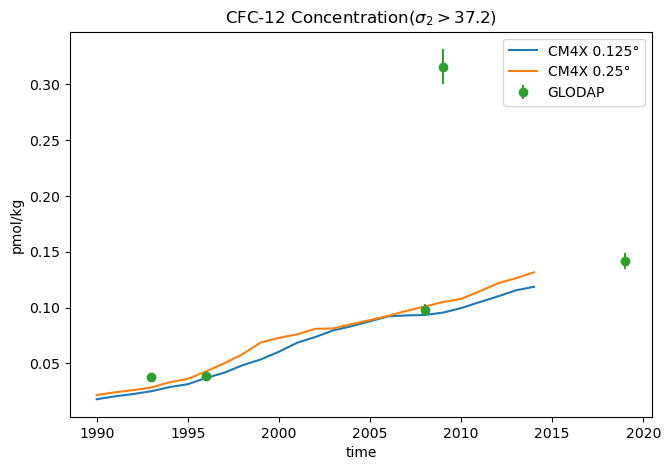

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))

(regrid_cfc12.sel(year = slice(1990, None)) * variable_kwargs["cfc12"]['conversion']).plot(label = "CM4X 0.125°", ax = ax)
(regrid_cfc12_lo.sel(year = slice(1990, None)) * variable_kwargs["cfc12"]['conversion']).plot(label = "CM4X 0.25°", ax = ax)
mask_ = GLODAP_profile.sigma2 > 37.2
cfcprof = (GLODAP_profile.G2cfc12 * mask_).mean("z")
cfcprof.plot.scatter(ax = ax)

ax.errorbar(cfcprof.time, cfcprof.values, yerr=0.05 * cfcprof.values, fmt="o", label = "GLODAP")
ax.legend()

ax.set_title("CFC-12 Concentration" + r"$(\sigma_2 > 37.2)$")
ax.set_ylabel("pmol/kg")

In [19]:
import cartopy.feature as cfeature;
fig, axes = plt.subplots(1, 2, figsize=(12.5, 5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude = 180)})

ax = axes[0]
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='grey', alpha = 0.9))
tmp = (((~np.isnan(cfc_gridded)).sum(["time", "z"]))).T

tmp.sel(lat = slice(-80, -40), lon = slice(-80, -0.1)).plot(ax = ax,transform=ccrs.PlateCarree(),
                                                          cbar_kwargs = {"label":"# of Observations",
                                                                        "orientation":"horizontal",
                                                                        "fraction":0.02})
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
ax.set_title("Number of Observations in Bins")

ax = axes[1]

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='grey', alpha = 0.4))
tmp = (cfc_gridded).sel(z = slice(-3000, -6000)).mean(["time", "z"]).T

tmp.sel(lat = slice(-80, -40), lon = slice(-80, -0.1)).plot(ax = ax,transform=ccrs.PlateCarree(), vmax = 1,
                                                          cbar_kwargs = {"label":"pmol/kg",
                                                                        "orientation":"horizontal",
                                                                        "fraction":0.02})
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.
ax.set_title("Mean CFC-12 Concentration")

# ax.coastlines()

SyntaxError: invalid syntax (493493413.py, line 25)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12.5, 5))

mask = ((~np.isnan(cfc_gridded)).sum(["time", "z"]) > 1).sel(lat = slice(-70, -60), lon = slice(-50, -40))
mask.T.plot(ax = axes[0],
                                                          cbar_kwargs = {"label":"mask",
                                                                        "orientation":"horizontal",
                                                                        "fraction":0.02})
axes[0].set_title("Mask")

GLODAP_profile = ds_GLODAPP.sel(lat = mask.lat, lon = mask.lon).mean(["lon", "lat"])
GLODAP_profile.G2cfc12.T.plot(vmax = 0.9, ax = axes[1],
                                                          cbar_kwargs = {"label":"pmol/kg",
                                                                        "orientation":"horizontal",
                                                                        "fraction":0.02})
axes[1].set_title("CFC-12 Concentration")
fig.tight_layout()

In [ ]:
GLODAP_profile = ds_GLODAPP.sel(lat = mask.lat, lon = mask.lon).mean(["lon", "lat"])
((GLODAP_profile.sigma2 > 37.2) * (GLODAP_profile.sigma2 < 37.25)).T.plot()

In [465]:
regrid_cfc12 = ds_regrid.sel(lat = mask.lat, lon = mask.lon)
weights = (regrid_cfc12.sigma2 > 37.2) * (regrid_cfc12.sigma2 < 37.25)
weights = weights * regrid_cfc12.thkcello * mask.T
regrid_cfc12 = (regrid_cfc12.cfc12 * weights).sum(["lat", "lon", "zl"]) / weights.sum(["lat", "lon", "zl"])
regrid_cfc12 = regrid_cfc12.compute()

In [466]:
regrid_cfc12_lo = ds_regrid_lo.sel(lat = mask.lat, lon = mask.lon)
weights = (regrid_cfc12_lo.sigma2 > 37.2)* (regrid_cfc12_lo.sigma2 < 37.25)
weights = weights * regrid_cfc12_lo.thkcello * mask.T
regrid_cfc12_lo = (regrid_cfc12_lo.cfc12 * weights).sum(["lat", "lon", "zl"]) / weights.sum(["lat", "lon", "zl"])
regrid_cfc12_lo = regrid_cfc12_lo.compute()

Text(0, 0.5, 'pmol/kg')

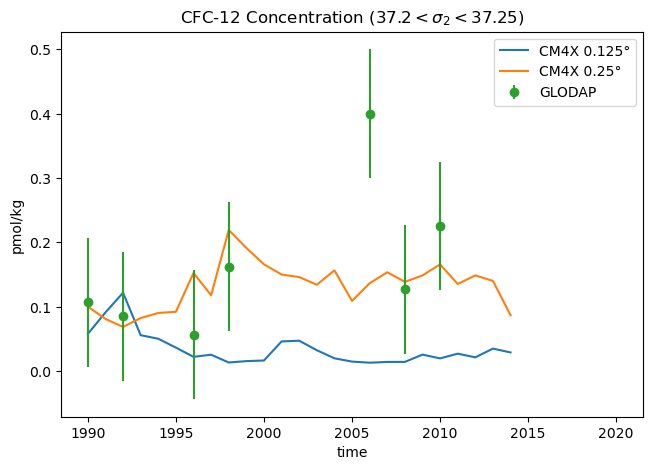

In [470]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))

(regrid_cfc12.sel(year = slice(1990, None)) * variable_kwargs["cfc12"]['conversion']).plot(label = "CM4X 0.125°", ax = ax)
(regrid_cfc12_lo.sel(year = slice(1990, None)) * variable_kwargs["cfc12"]['conversion']).plot(label = "CM4X 0.25°", ax = ax)
mask_ = (GLODAP_profile.sigma2 > 37.2) * (GLODAP_profile.sigma2 < 37.25) 
cfcprof = (GLODAP_profile.G2cfc12 * mask_).mean("z")
cfcprof.plot.scatter(ax = ax)

ax.errorbar(cfcprof.time, cfcprof.values, yerr=0.05 * cfcprof.values, fmt="o", label = "GLODAP")
ax.legend()

ax.set_title("CFC-12 Concentration " + r"$(37.2 < \sigma_2 < 37.25)$")
ax.set_ylabel("pmol/kg")